In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
from torch.utils.data import Dataset, DataLoader

In [2]:
import pandas as pd
import numpy as np

In [ ]:
from tqdm.notebook import tqdm

In [3]:
from sklearn.preprocessing import MinMaxScaler

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, classification_report

In [42]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

In [6]:
data_path = '..\\data\\'

In [7]:
X_train_val = np.load(data_path + 'features_train_val.npy')
y_train_val = np.load(data_path + 'y_train.npy')
X_test = np.load(data_path + 'features_test.npy')
y_test = np.load(data_path + 'y_test.npy')

In [8]:
labels_train_val = np.array([np.where(r==1)[0][0] for r in y_train_val])
labels_test = np.array([np.where(r==1)[0][0] for r in y_test])

Нормализуем числовые предикторы

In [9]:
scaler = MinMaxScaler()

In [10]:
X_train_val[:, :-27] = scaler.fit_transform(X_train_val[:, :-27])

In [11]:
X_test[:, :-27] = scaler.transform(X_test[:, :-27])

Разделим первую часть выборки на обучающую и валидационную части

In [12]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, labels_train_val, test_size=0.3, random_state=42)

Определим класс Dataset для работы с данными в PyTorch

In [13]:
class ClassifierDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

In [14]:
train_dataset = ClassifierDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
val_dataset = ClassifierDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
test_dataset = ClassifierDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

Зададим параметры для построения модели

In [102]:
EPOCHS = 300
BATCH_SIZE = 512
LEARNING_RATE = 0.00005
NUM_FEATURES = X_train.shape[1]
NUM_CLASSES = 6

In [103]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE)

val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE)

test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE)

Определим модель

In [104]:
class MulticlassClassification(nn.Module):
    def __init__(self, num_feature, num_class):
        super(MulticlassClassification, self).__init__()
        
        self.layer_1 = nn.Linear(num_feature, 256)
        self.layer_2 = nn.Linear(256, 128)
        self.layer_out = nn.Linear(128, num_class)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.4)
        self.softmax = nn.Softmax(dim=1)
        
        self.batchnorm1 = nn.BatchNorm1d(256)
        self.batchnorm2 = nn.BatchNorm1d(128)
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        
        x = self.layer_2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_out(x)
        x = self.softmax(x)
        
        return x

In [105]:
model = MulticlassClassification(num_feature = NUM_FEATURES, num_class=NUM_CLASSES)

Определим функцию потерь и оптимизатор

In [106]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
print(model)

MulticlassClassification(
  (layer_1): Linear(in_features=117, out_features=256, bias=True)
  (layer_2): Linear(in_features=256, out_features=128, bias=True)
  (layer_out): Linear(in_features=128, out_features=6, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.4, inplace=False)
  (softmax): Softmax(dim=1)
  (batchnorm1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [107]:
def multi_acc(y_pred, y_test):
    # y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    y_pred_softmax = y_pred
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc) * 100
    
    return acc

In [108]:
accuracy_stats = {
    'train': [],
    'val': []
}
loss_stats = {
    'train': [],
    'val': []
}

Процесс обучения

In [109]:
print("Begin training.")
for e in tqdm(range(1, EPOCHS+1)):
    
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    train_epoch_f1 = 0
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = multi_acc(y_train_pred, y_train_batch)
        train_f1 = f1_score(y_train_batch.cpu().detach(), torch.max(y_train_pred, dim = 1)[1].cpu().detach(), average='macro')
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        train_epoch_f1 += train_f1.item()
        
        
    # VALIDATION    
    with torch.no_grad():
        
        val_epoch_loss = 0
        val_epoch_acc = 0
        val_epoch_f1 = 0
        
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            
            y_val_pred = model(X_val_batch)
                        
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = multi_acc(y_val_pred, y_val_batch)
            val_f1 = f1_score(y_val_batch.cpu(), torch.max(y_val_pred, dim = 1)[1].cpu(), average='macro')
            
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()
            val_epoch_f1 += val_f1.item()
            
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
                              
    
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')
    print('Train f1 = {0:.5f}'.format(train_epoch_f1/len(train_loader)))
    print('Val f1 = {0:.5f}'.format(val_epoch_f1/len(val_loader)))

Begin training.


Epoch 001: | Train Loss: 1.79182 | Val Loss: 1.78909 | Train Acc: 0.000| Val Acc: 0.000
Train f1 = 0.15932
Val f1 = 0.08095
Epoch 002: | Train Loss: 1.76609 | Val Loss: 1.77523 | Train Acc: 0.000| Val Acc: 0.000
Train f1 = 0.22256
Val f1 = 0.22157
Epoch 003: | Train Loss: 1.73944 | Val Loss: 1.74617 | Train Acc: 0.000| Val Acc: 0.000
Train f1 = 0.28998
Val f1 = 0.30485
Epoch 004: | Train Loss: 1.71789 | Val Loss: 1.70918 | Train Acc: 0.000| Val Acc: 0.000
Train f1 = 0.33265
Val f1 = 0.36986
Epoch 005: | Train Loss: 1.69663 | Val Loss: 1.67542 | Train Acc: 0.000| Val Acc: 80.000
Train f1 = 0.36462
Val f1 = 0.40887
Epoch 006: | Train Loss: 1.67024 | Val Loss: 1.64761 | Train Acc: 27.273| Val Acc: 100.000
Train f1 = 0.41064
Val f1 = 0.43233
Epoch 007: | Train Loss: 1.65275 | Val Loss: 1.62417 | Train Acc: 72.727| Val Acc: 100.000
Train f1 = 0.43083
Val f1 = 0.45098
Epoch 008: | Train Loss: 1.63185 | Val Loss: 1.60353 | Train Acc: 81.818| Val Acc: 100.000
Train f1 = 0.44503
Val f1 = 0.4699

Epoch 066: | Train Loss: 1.21348 | Val Loss: 1.21053 | Train Acc: 100.000| Val Acc: 100.000
Train f1 = 0.90231
Val f1 = 0.89259
Epoch 067: | Train Loss: 1.20795 | Val Loss: 1.20796 | Train Acc: 100.000| Val Acc: 100.000
Train f1 = 0.90466
Val f1 = 0.89339
Epoch 068: | Train Loss: 1.20638 | Val Loss: 1.20529 | Train Acc: 100.000| Val Acc: 100.000
Train f1 = 0.90583
Val f1 = 0.89712
Epoch 069: | Train Loss: 1.20278 | Val Loss: 1.20294 | Train Acc: 100.000| Val Acc: 100.000
Train f1 = 0.90941
Val f1 = 0.89748
Epoch 070: | Train Loss: 1.20100 | Val Loss: 1.20078 | Train Acc: 100.000| Val Acc: 100.000
Train f1 = 0.90837
Val f1 = 0.89918
Epoch 071: | Train Loss: 1.19743 | Val Loss: 1.19849 | Train Acc: 100.000| Val Acc: 100.000
Train f1 = 0.91291
Val f1 = 0.89914
Epoch 072: | Train Loss: 1.19676 | Val Loss: 1.19655 | Train Acc: 100.000| Val Acc: 100.000
Train f1 = 0.91121
Val f1 = 0.89954
Epoch 073: | Train Loss: 1.19426 | Val Loss: 1.19470 | Train Acc: 100.000| Val Acc: 100.000
Train f1 = 0

Epoch 131: | Train Loss: 1.12680 | Val Loss: 1.14300 | Train Acc: 100.000| Val Acc: 100.000
Train f1 = 0.95178
Val f1 = 0.91880
Epoch 132: | Train Loss: 1.12602 | Val Loss: 1.14220 | Train Acc: 100.000| Val Acc: 100.000
Train f1 = 0.95104
Val f1 = 0.91854
Epoch 133: | Train Loss: 1.12377 | Val Loss: 1.14197 | Train Acc: 100.000| Val Acc: 100.000
Train f1 = 0.95363
Val f1 = 0.91896
Epoch 134: | Train Loss: 1.12327 | Val Loss: 1.14183 | Train Acc: 100.000| Val Acc: 100.000
Train f1 = 0.95062
Val f1 = 0.91931
Epoch 135: | Train Loss: 1.12368 | Val Loss: 1.14094 | Train Acc: 100.000| Val Acc: 100.000
Train f1 = 0.95199
Val f1 = 0.91787
Epoch 136: | Train Loss: 1.12280 | Val Loss: 1.14016 | Train Acc: 100.000| Val Acc: 100.000
Train f1 = 0.95177
Val f1 = 0.91977
Epoch 137: | Train Loss: 1.12173 | Val Loss: 1.14039 | Train Acc: 100.000| Val Acc: 100.000
Train f1 = 0.95385
Val f1 = 0.91987
Epoch 138: | Train Loss: 1.12043 | Val Loss: 1.14005 | Train Acc: 100.000| Val Acc: 100.000
Train f1 = 0

Epoch 196: | Train Loss: 1.09593 | Val Loss: 1.12607 | Train Acc: 100.000| Val Acc: 100.000
Train f1 = 0.96948
Val f1 = 0.93039
Epoch 197: | Train Loss: 1.09443 | Val Loss: 1.12552 | Train Acc: 100.000| Val Acc: 100.000
Train f1 = 0.97150
Val f1 = 0.93147
Epoch 198: | Train Loss: 1.09582 | Val Loss: 1.12583 | Train Acc: 100.000| Val Acc: 100.000
Train f1 = 0.96943
Val f1 = 0.93072
Epoch 199: | Train Loss: 1.09330 | Val Loss: 1.12554 | Train Acc: 100.000| Val Acc: 100.000
Train f1 = 0.97136
Val f1 = 0.93147
Epoch 200: | Train Loss: 1.09459 | Val Loss: 1.12520 | Train Acc: 100.000| Val Acc: 100.000
Train f1 = 0.97156
Val f1 = 0.93147
Epoch 201: | Train Loss: 1.09502 | Val Loss: 1.12485 | Train Acc: 100.000| Val Acc: 100.000
Train f1 = 0.97093
Val f1 = 0.93294
Epoch 202: | Train Loss: 1.09274 | Val Loss: 1.12468 | Train Acc: 100.000| Val Acc: 100.000
Train f1 = 0.97200
Val f1 = 0.93220
Epoch 203: | Train Loss: 1.09303 | Val Loss: 1.12439 | Train Acc: 100.000| Val Acc: 100.000
Train f1 = 0

Epoch 261: | Train Loss: 1.07929 | Val Loss: 1.11945 | Train Acc: 100.000| Val Acc: 100.000
Train f1 = 0.98071
Val f1 = 0.93344
Epoch 262: | Train Loss: 1.07797 | Val Loss: 1.11796 | Train Acc: 100.000| Val Acc: 100.000
Train f1 = 0.98243
Val f1 = 0.93614
Epoch 263: | Train Loss: 1.07818 | Val Loss: 1.11834 | Train Acc: 100.000| Val Acc: 100.000
Train f1 = 0.98119
Val f1 = 0.93441
Epoch 264: | Train Loss: 1.07776 | Val Loss: 1.11808 | Train Acc: 100.000| Val Acc: 100.000
Train f1 = 0.98325
Val f1 = 0.93593
Epoch 265: | Train Loss: 1.07726 | Val Loss: 1.11782 | Train Acc: 100.000| Val Acc: 100.000
Train f1 = 0.98149
Val f1 = 0.93498
Epoch 266: | Train Loss: 1.07764 | Val Loss: 1.11814 | Train Acc: 100.000| Val Acc: 100.000
Train f1 = 0.98274
Val f1 = 0.93380
Epoch 267: | Train Loss: 1.07733 | Val Loss: 1.11830 | Train Acc: 100.000| Val Acc: 100.000
Train f1 = 0.98176
Val f1 = 0.93446
Epoch 268: | Train Loss: 1.07638 | Val Loss: 1.11722 | Train Acc: 100.000| Val Acc: 100.000
Train f1 = 0

Обработка тестовой части набора данных

In [110]:
y_pred_list = []
y_pred_proba_list = []
with torch.no_grad():
    model.eval()
    for X_batch, _ in test_loader:
        y_test_pred = model(X_batch)
        _, y_pred_tags = torch.max(y_test_pred, dim = 1)
        for x in y_pred_tags.cpu().numpy():
            y_pred_list.append(x)
        for x in y_test_pred.cpu().numpy():
            y_pred_proba_list.append(x)
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
y_pred_proba_list = [a.squeeze().tolist() for a in y_pred_proba_list]

Изучение результатов

<AxesSubplot:>

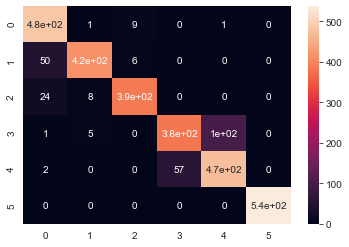

In [111]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(labels_test, y_pred_list))

sns.heatmap(confusion_matrix_df, annot=True)

In [112]:
print(classification_report(labels_test, y_pred_list))

              precision    recall  f1-score   support

           0       0.86      0.98      0.92       496
           1       0.97      0.88      0.92       471
           2       0.96      0.92      0.94       420
           3       0.87      0.78      0.83       491
           4       0.82      0.89      0.86       532
           5       1.00      1.00      1.00       537

    accuracy                           0.91      2947
   macro avg       0.91      0.91      0.91      2947
weighted avg       0.91      0.91      0.91      2947



Подсчёт AUC ROC и F1-Score

In [114]:
f1_score(labels_test, y_pred_list, average='macro')

0.9104279274791661

In [113]:
roc_auc_score(labels_test, y_pred_proba_list, multi_class='ovo')

0.9859229508602543